Best output with the best ROC AUC of 0.92 

Epoch 1/10, Loss: 0.2489
Validation Loss: 0.2457, Accuracy: 0.9176
Epoch 2/10, Loss: 0.7278
Validation Loss: 0.6932, Accuracy: 0.4940
Epoch 3/10, Loss: 0.4556
Validation Loss: 0.2881, Accuracy: 0.8975
Epoch 4/10, Loss: 0.2436
Validation Loss: 0.2509, Accuracy: 0.9137
Epoch 5/10, Loss: 0.2342
Validation Loss: 0.2405, Accuracy: 0.9172
Epoch 6/10, Loss: 0.2336
Validation Loss: 0.2373, Accuracy: 0.9169
Epoch 7/10, Loss: 0.2348
Validation Loss: 0.2369, Accuracy: 0.9176
Epoch 8/10, Loss: 0.2350
Validation Loss: 0.2363, Accuracy: 0.9177
Epoch 9/10, Loss: 0.2314
Validation Loss: 0.2389, Accuracy: 0.9174
Epoch 10/10, Loss: 0.2326
Validation Loss: 0.2412, Accuracy: 0.9181
Confusion Matrix:
[[2993    5]
 [ 484 2487]]


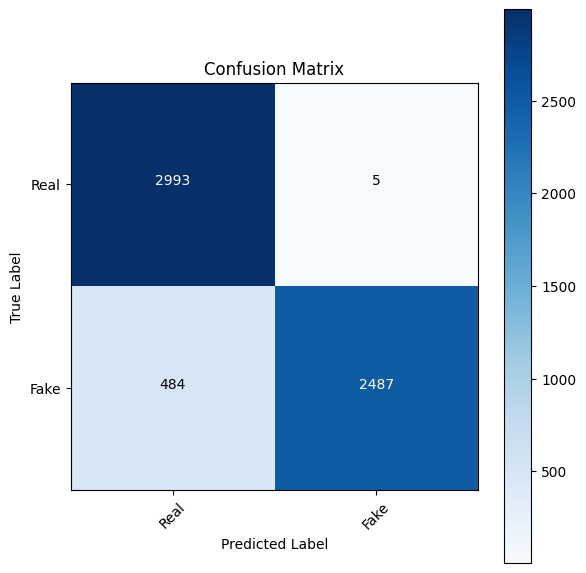

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      2998
           1       1.00      0.84      0.91      2971

    accuracy                           0.92      5969
   macro avg       0.93      0.92      0.92      5969
weighted avg       0.93      0.92      0.92      5969



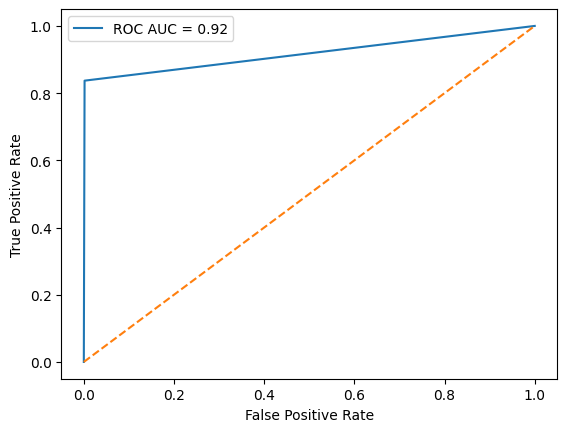

Model saved as resnet18_new_deepfake_detector.pth


In [25]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Define paths
fake_path = "C:\\Users\\yakup\\Desktop\\Special Dataset\\Frames\\Fake"
real_path = "C:\\Users\\yakup\\Desktop\\Special Dataset\\Frames\\Real"

# Parameters
batch_size = 64 
num_epochs = 10
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = "C:\\Users\\yakup\\Desktop\\Special Dataset\\Frames"
dataset = datasets.ImageFolder(data_dir, transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

# Model setup
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function with validation
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")
        validate(model, val_loader, criterion)

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/total:.4f}")

def evaluate(model, test_loader):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

def plot_roc(labels, preds):
    fpr, tpr, _ = roc_curve(labels, preds)
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc(fpr, tpr):.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    classes = ['Real', 'Fake']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, f"{conf_matrix[i, j]}",
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

# Training the model
train(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Evaluate the model
labels, preds = evaluate(model, test_loader)
conf_matrix = confusion_matrix(labels, preds)

print("Confusion Matrix:")
print(conf_matrix)
plot_confusion_matrix(conf_matrix)

print("Classification Report:")
print(classification_report(labels, preds))

plot_roc(labels, preds)

torch.save(model.state_dict(), "resnet18_new_deepfake_detector.pth")
print("Model saved as resnet18_new_deepfake_detector.pth")


Other models were trained after this markdown, but the codes were lost while merging the files at GitHub.

Confusion Matrix:
[[3966   77]
 [ 518 3521]]


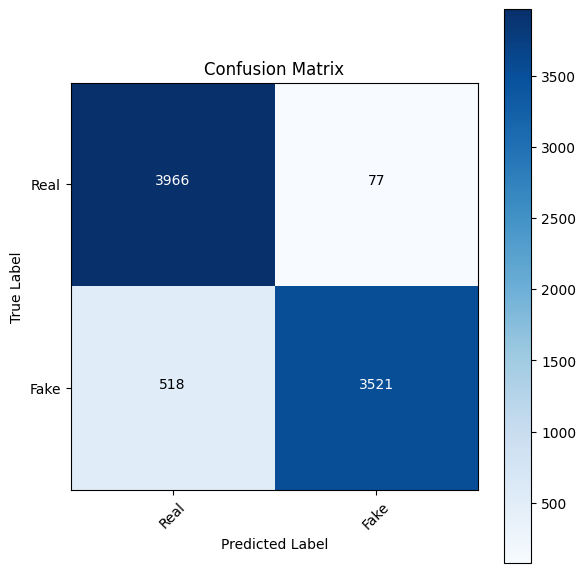

In [19]:
conf_matrix = confusion_matrix(labels, preds)
print("Confusion Matrix:")
print(conf_matrix)
plot_confusion_matrix(conf_matrix)